In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
!pip -q install torcheval
!pip -q install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.9 MB/s eta 0:00:00


# Optimizer

<img src="image.png" alt="Sceneary" width="250">

We use optimizers to update parameters. We will explore different strategies, such as SGD (Stochastic gradient descent), momentum, RMSProp, and Adam. This blog is based on FastAI [lesson 18](https://course.fast.ai/Lessons/lesson18.html).

In [ ]:
#|export
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.xtras import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [ ]:
dls = get_dls()
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy(device='cpu'))
astats = ActivationStats(fc.risinstance(GeneralRelu), plot=True)
cbs = [DeviceCB(), metrics, ProgressCB(plot=False), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

## Optimizers

Here is the `SGD` class, a base class for all other optimizers we will define. For updating parameters, we need parameters, learning rate, and weight decay (optional). We will learn about what weight decay is later. We have `step`, `reg_step`, `opt_step`, and `zero_grad`. `step` is divided into `reg_step` and `opt_step`. `reg_step` is the weight decay part which tries to regulate the growth of weights. `opt_step` is the update part using gradient and learning rate.

In [ ]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        self.params = list(params)
        self.lr = lr
        self.wd = wd
        # Useful for Adam
        self.i = 1

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1

    def reg_step(self, p):
        if self.wd != 0: p *= (1 - self.wd * self.lr)

    def opt_step(self, p):
        p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

accuracy,loss,epoch,train,time
0.758,0.669,0,True,00:18
0.826,0.473,0,False,00:01


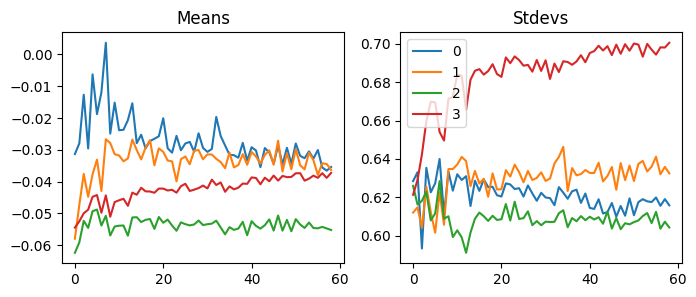

In [ ]:
set_seed(42)
model = get_model(act=act_gr, norm=nn.BatchNorm2d)
learn = TrainLearner(model, dls, loss_func=F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)
learn.fit(1)

As we can see, SGD is the one we have been using so far. Before we jump into other concepts, I want to examine how gradient changes in each strategy. So, we can use the backward hook to graph means and standard deviations like we did with weights.

In [ ]:
grad_means = [[] for _ in model]
grad_stds = [[] for _ in model]

In [ ]:
def append_grads(i, module, grad_input, grad_output):
    if grad_input[0] is not None:
        acts = to_cpu(grad_input[0])
        grad_means[i].append(acts.mean())
        grad_stds[i].append(acts.std())

In [ ]:
set_seed(42)
model = get_model(act=act_gr, norm=nn.BatchNorm2d)

In [ ]:
for i, m in enumerate(model): m.register_full_backward_hook(partial(append_grads, i))

accuracy,loss,epoch,train,time
0.758,0.669,0,True,00:12
0.822,0.482,0,False,00:01


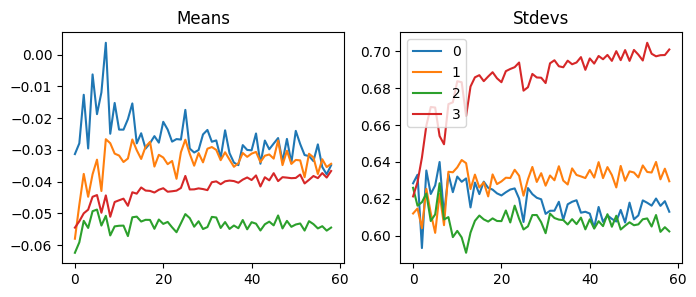

In [ ]:
learn = TrainLearner(model, dls, loss_func=F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)
learn.fit(1)

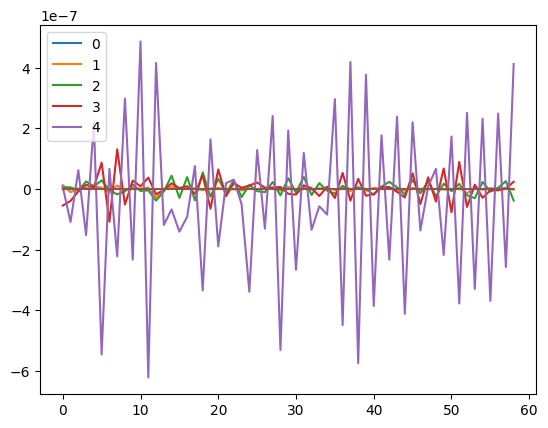

In [ ]:
for o in grad_means: plt.plot(o)
plt.legend(range(5));

Let's create a `BackwardHook` class to keep the stats in each hook.

In [ ]:
class BackwardHook:
    def __init__(self, m, f): self.hook = m.register_full_backward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [ ]:
def append_grads(hook, module, grad_input, grad_output):
    if not hasattr(hook, 'stats'): hook.stats = [[], []]
    if grad_input[0] is not None:
        acts = to_cpu(grad_input[0])
        hook.stats[0].append(acts.mean())
        hook.stats[1].append(acts.std())

In [ ]:
set_seed(42)
model = get_model(act=act_gr, norm=nn.BatchNorm2d)

In [ ]:
hooks = [BackwardHook(m, append_grads) for m in model[:5].children()]

accuracy,loss,epoch,train,time
0.757,0.669,0,True,00:12
0.824,0.477,0,False,00:01


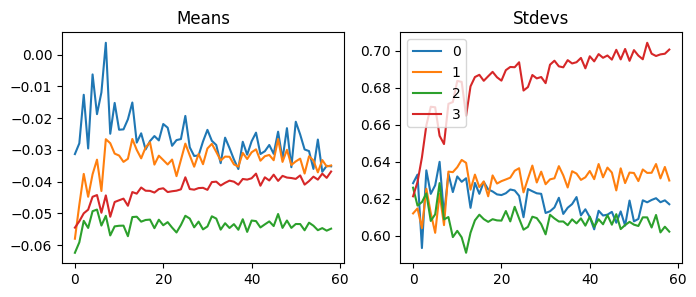

In [ ]:
learn = TrainLearner(model, dls, loss_func=F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)
learn.fit(1)

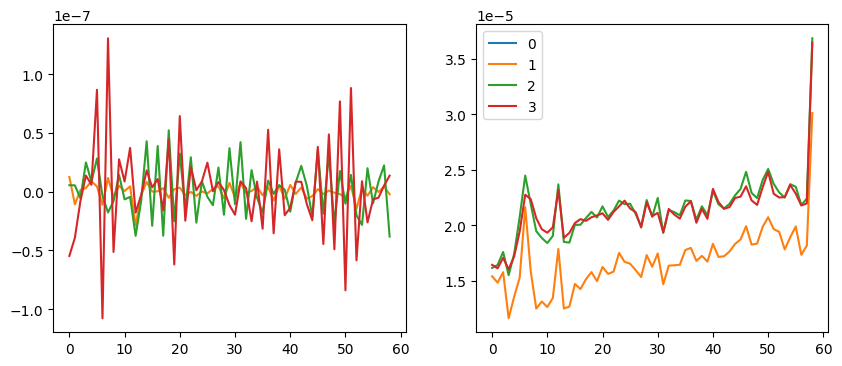

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for h in hooks[:-1]:
    for i in 0,1: axs[i].plot(h.stats[i])
    h.remove()
plt.legend(range(4));

Okay. We can compare this to others later. Because the last hook changed way more than others, we will only look at others. For the averages, notice y values are scaled with `1e-7`.

## Weight decay

In `SGD`, we had the option to use weight decay. Weight decay is a regularization method. This keeps the absolute value of weights small. When those values are large, models get complex and are more challenging to generalize. So, let's see how weight decay works.

::: {.callout-tip title="What is regularization?"}

Regularization is a way to interfere with the training of the model. Why do we want the model not to train well? Training well was our goal so far. That's why we explored various initialization techniques and implemented layer norm and batch norm.

However, our model trains very well and is starting to overfit. What does this mean? Let's say we created flashcards to memorize for an upcoming Spanish test. Then, we study cards in order without shuffling. Because we want to maximize the score with minimal effort, we will memorize the order of words. No matter how much we study and get good score on practice quiz, we will do bad on the test. Similar thing is going on with the neural net. It is taking short cut to get a good score on the loss function. So we force our model to learn generally.

:::

This is the definition of weight decay according to [chapter 5](https://www.deeplearningbook.org/contents/ml.html) of [deep learning](https://www.deeplearningbook.org/lecture_slides.html) by Ian Goodfellow et al.

$$ L \leftarrow L + (w^Tw) * wd$$

where $L$ is the loss, $w$ is weight, and $wd$ is weight decay. Usually, weight decay is a small value. Let's see how we can simplify this equation with code.

If we simplify $w^Tw$ into $w^2$, we get:

$$ L \leftarrow L + (\sum{w^2}) * wd $$

In code, it is this:
``` python
L = L + sum(w**2) * wd
```

If we take the derivative of the right side, we have:

$$ \frac{\partial L}{\partial w} + (\sum{2w}) * wd $$

``` python
w.grad = w.grad + 2*sum(w) * wd
```

From this, we can incorporate 2 into $wd$. So, we are left with this:

$$ \frac{\partial L}{\partial w} + (\sum{w}) * wd $$

``` python
w.grad = w.grad + sum(w) * wd
```

From the FastAI course, we can see the weight decay and L2 regularization in code, which does the same thing **in this case**:

``` python
weight -= lr*wd*weight
```

...vs...

``` python
weight.grad += wd*weight
```

When I first looked at this, I was not convinced that these represented the same thing. If you are like me, let's look at these in a different angle. So, this is how we update the weights without weight decay:

$$w \leftarrow w-lr\frac{\partial L}{\partial w} \tag{1}$$

where $w$ is weight, $lr$ is learning rate, $L$ is a loss function, and $wd$ is weight decay.

``` python
w -= lr*w.grad
```
where `w.grad` is a gradient of loss repect to weights.

And this is how we add weight decay:

$$ w \leftarrow w-lr\frac{\partial L}{\partial w}-lr*wd*w \tag{2} $$

``` python
w -= lr*w.grad - lr*wd*w
```

We can also write it this way:

$$ w \leftarrow w-lr(\frac{\partial L}{\partial w}+wd*w) \tag{3} $$

``` python
w -= lr*(w.grad + wd*w)
```

Which is the same thing as:
``` python
w.grad += wd*w
w -= lr*w.grad
```

Now, it is easier to see that they are doing the same thing here. So, first one from fastai is the same thing as the equation (2) without the gradient part. And the second one is the same thing as the equation (3) inside of the parenthesis. This part multiplied by learning rate gets subtracted from the weights, which is the same thing as bigger gradient.

::: {.callout-important}

Althoug they are the same thing in standard stochastic gradient descent, they are different in adaptive stochastic gradient descent, like Adam according to [DECOUPLED WEIGHT DECAY REGULARIZATION](https://arxiv.org/pdf/1711.05101.pdf) by Ilya Loshchilov & Frank Hutter.

:::

::: {.callout-note}

More on weight decay from [Lesson 7](https://www.youtube.com/watch?v=p4ZZq0736Po&list=PLfYUBJiXbdtSvpQjSnJJ_PmDQB_VyT5iU&index=7&t=5946s) of the FastAI course.

:::

::: {.callout-important}

It's very important to remember that weight decay cannot be used with batch norm. Even if weight decay regularizes the growth of weights, batch norm can make them bigger by multiplying weights by its learned parameters.

:::

## RMSprop

We can improve stochastic gradient descent to take bigger steps when possible. Therefore, we can get better results faster with RMSprop. RMSprop came from [lecture](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf) by G. Hinton. How does it know when it can take bigger steps? So, RMSprop uses the gradient squared, which is a variance (how spread out the gradient is). If the variance is considerable, there are multiple ways to reduce the loss, and it needs to be clarified which way it should go. Therefore, it should not step too much. On the other hand, if the variance is tiny, there is a clear direction on where to step. So, it should take a big step to reduce the loss quickly.

By dividing the gradient of loss by its variance, RMSprop figures out how big it can step. Just like Batch norm, it uses epsiolon just in case the variance is too small.

In [ ]:
class RMSprop(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr, wd)
        self.sqr_mom = sqr_mom
        self.eps = eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg*self.sqr_mom + (1-self.sqr_mom)*p.grad**2
        p -= self.lr * p.grad / (p.sqr_avg.sqrt() + self.eps)

accuracy,loss,epoch,train,time
0.766,0.660,0,True,00:10
0.829,0.481,0,False,00:01


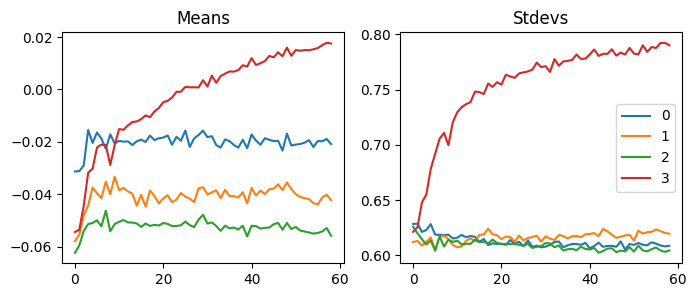

In [ ]:
set_seed(42)
model = get_model(act=act_gr, norm=nn.BatchNorm2d)
learn = TrainLearner(model, dls, loss_func=F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSprop)
learn.fit(1)

In [ ]:
set_seed(42)
model = get_model(act=act_gr, norm=nn.BatchNorm2d)
hooks = [BackwardHook(m, append_grads) for m in model[:5].children()]

accuracy,loss,epoch,train,time
0.765,0.662,0,True,00:12
0.836,0.470,0,False,00:01


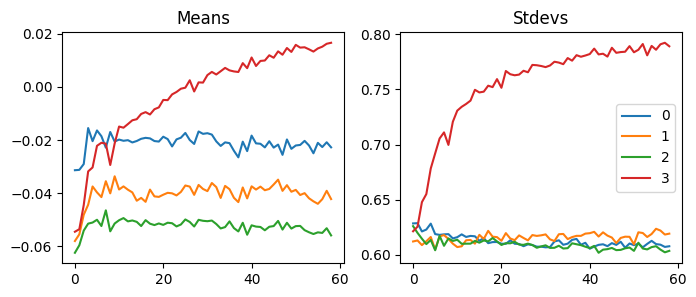

In [ ]:
learn = TrainLearner(model, dls, loss_func=F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSprop)
learn.fit(1)

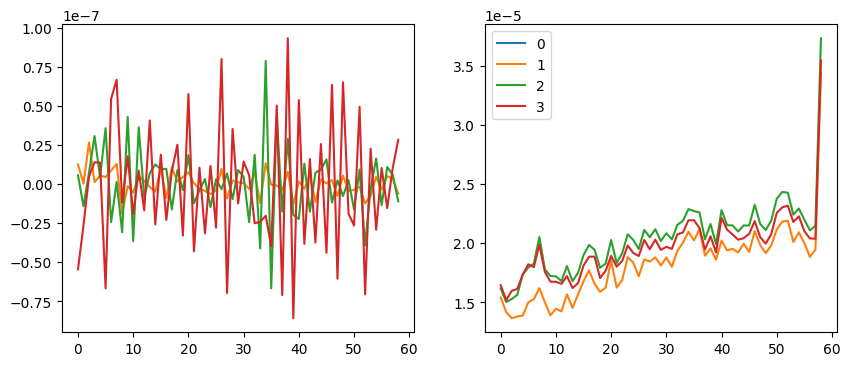

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
for h in hooks[:-1]:
    for i in 0, 1: axs[i].plot(h.stats[i])
    h.remove()
plt.legend(range(4));

Compared to `SGD`, this is scaled with `1e-8`, so this is more stable. This explains why it works better than `SGD`.

## Adam

[Adam](https://arxiv.org/abs/1412.6980) is one of the most widely used optimizers. We can think of this as RMSprop with momentum. The paper has a lot of math, but let's focus on intuition here. If we convert the pseudo code from **Algorithm 1** into Python, we get something like this:

In [ ]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr, wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps
        for p in self.params:                                       # Initialize with zeros
            p.m = torch.zeros_like(p.data)
            p.v = torch.zeros_like(p.data)

    def opt_step(self, p):
        p.m = self.beta1 * p.m + (1 - self.beta1) * p.grad.data     # Update biased first moment estimate
        p.v = self.beta2 * p.v + (1 - self.beta2) * p.grad.data**2  # Update biased second raw moment estimate
        m_hat = p.m / (1 - self.beta1**self.i)                      # Compute bias-corrected first moment estimate
        v_hat = p.v / (1 - self.beta2**self.i)                      # Compute bias-corrected second moment estimate
        p -= self.lr * m_hat / (v_hat.sqrt() + self.eps)            # Update parameters

In this algorithm, we have exponential moving averages of the gradient (`p.m`) and the squared gradient (`p.v`). They are initialized to zeros at first, so they are biased toward zeros. To correct the bias, we make them bigger by dividing by `1-self.beta1**self.i`. Because it increments `self.i` every batch, this becomes one later in the training process. And we are left with `m_hat = p.m`. So, we divide the gradients by itself. Let's see what this means by looking at `t1`.

In [ ]:
t1 = tensor([-100, -1, -0.01, 0.01, 1, 100])
t1

tensor([  -100.00,     -1.00,     -0.01,      0.01,      1.00,    100.00])

In [ ]:
t1 / (t1**2).sqrt()

tensor([-1., -1., -1.,  1.,  1.,  1.])

So, whether the gradients are big or small, they will be -1 or 1. However, we use exponentially moving averages, and `beta1` and `beta2` have different momentums. Because `beta2` has a more significant value than `beta1`, the second moment (variance) changes slowly. When the training starts, the gradients and the gradient squares will be small. As the model figures out where to go, the gradient will get bigger, but the gradient square will be smaller. This means that it will update parameters with bigger numbers. On the other hand, even if the gradient gets smaller, the gradient squared will be bigger, and it will update parameters with smaller numbers.

As a result, Adam updates parameters faster in the right directions. This explains why it performs better than others.

accuracy,loss,epoch,train,time
0.802,0.558,0,True,00:11
0.859,0.395,0,False,00:01
0.877,0.337,1,True,00:11
0.874,0.340,1,False,00:01


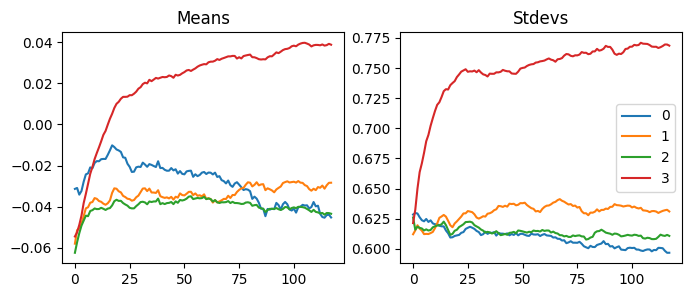

In [ ]:
set_seed(42)
model = get_model(act=act_gr, norm=nn.BatchNorm2d)
learn = TrainLearner(model, dls, loss_func=F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(2)

In [ ]:
set_seed(42)
model = get_model(act=act_gr, norm=nn.BatchNorm2d)
hooks = [BackwardHook(m, append_grads) for m in model[:5].children()]

accuracy,loss,epoch,train,time
0.803,0.557,0,True,00:12
0.856,0.395,0,False,00:01


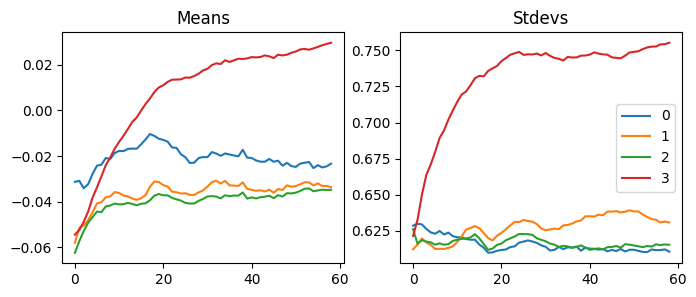

In [ ]:
learn = TrainLearner(model, dls, loss_func=F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(1)

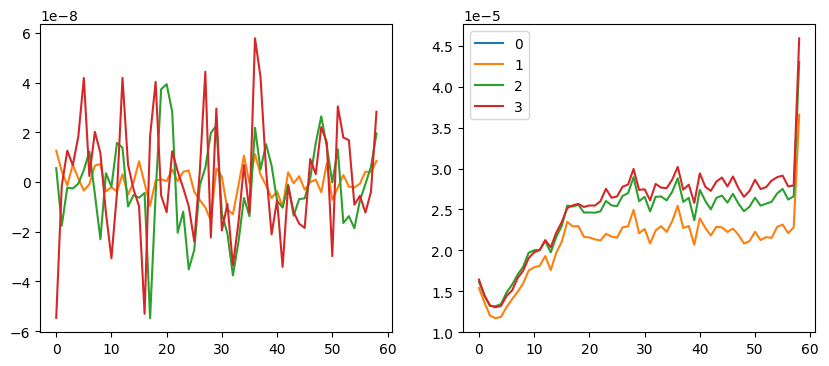

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
for h in hooks[:-1]:
    for i in 0, 1: axs[i].plot(h.stats[i])
    h.remove()
plt.legend(range(5));

Like `RMSprop`, Adam's gradients are scaled with `1e-8`. However, there are less ups and downs in this graph.

Just like batch norm and layer norm, we could try absolute value instead of squaring and squaring rooting.

In [ ]:
class Adam2(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr, wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps
        for p in self.params:
            p.m = torch.zeros_like(p.data)
            p.v = torch.zeros_like(p.data)

    def opt_step(self, p):
        p.m = self.beta1 * p.m + (1 - self.beta1) * p.grad.data       # Update biased first moment estimate
        p.v = self.beta2 * p.v + (1 - self.beta2) * p.grad.data.abs() # Update biased second raw moment estimate
        m_hat = p.m / (1 - self.beta1**self.i)                        # Compute bias-corrected first moment estimate
        v_hat = p.v / (1 - self.beta2**self.i)                        # Compute bias-corrected second moment estimate
        p -= self.lr * m_hat / (v_hat + self.eps)                     # Update parameters

accuracy,loss,epoch,train,time
0.804,0.554,0,True,00:11
0.854,0.407,0,False,00:01
0.876,0.336,1,True,00:11
0.876,0.339,1,False,00:01


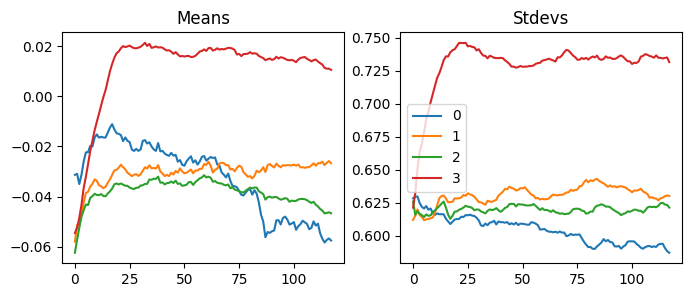

In [ ]:
set_seed(42)
model = get_model(act=act_gr, norm=nn.BatchNorm2d)
learn = TrainLearner(model, dls, loss_func=F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=partial(Adam2, beta2=0.9, eps=1e-8))
learn.fit(2)

It was a bit better this time.

## Conclusion

In this blog, we talked about optimization using `SGD`, `RMSprop`, and `Adam`. We also talked about weight decay. We also looked at gradients of the loss for each layer, and how each optimization techniques varied. Next blog, we will go over schedulers to change learning rates.